# 3. Работа с Big Data

In [1]:
import os
os.environ['PYSPARK_PYTHON'] = 'python'
os.environ['HADOOP_USER_NAME'] = 'root'  # Обход проверки пользователя

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder \
    .appName("Test") \
    .master("local[*]") \
    .config("spark.driver.host", "localhost") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

## 3.1. Spark SQL (каталог, метаданные)

Каталог (Catalog) — это абстракция в Spark SQL, которая предоставляет API для:
- Управления базами данных (databases)
- Работы с таблицами (tables)
- Доступа к представлениям (views)
- Хранения метаданных (схем, типов данных, партиций)

Встроенный каталог vs Hive Metastore
| Особенность | Встроенный каталог | Hive Metastore |
|- |- |- |
| Где хранятся метаданные? | В памяти (исчезают после завершения сессии) | Во внешней БД (MySQL, PostgreSQL) |
| Когда использовать? | Для временных таблиц | Для постоянных таблиц в продакшене |
| Доступ из других приложений | Нет| Да (через Hive, Impala и др.) |

Работа с каталогом через SparkSession

Показать все базы данных
`spark.catalog.listDatabases()`  
Показать все таблицы в текущей БД
`spark.catalog.listTables()`  
Показать все колонки таблицы
`spark.catalog.listColumns(df_Titanic)`

Создание и управление базами данных
Создать новую БД
`spark.sql("CREATE DATABASE IF NOT EXISTS my_db")`  
Переключиться на БД
`spark.catalog.setCurrentDatabase("my_db")`  
Удалить БД (осторожно!)
`spark.sql("DROP DATABASE IF EXISTS my_db CASCADE")`

Временные vs постоянные таблицы

| Тип | Временная таблица | Постоянная таблица |
|- |- |- |
| Видимость | Только в текущей сессии Spark | Доступна всем сессиям |
| Хранение метаданных | В памяти | В Hive Metastore |
| Хранение данных | Зависит от источника| Сохраняется на HDFS/S3 |

Временная таблица (исчезнет после завершения сессии)
`df.createOrReplaceTempView("temp_titanic")`  
Постоянная таблица (сохранится в каталоге Hive)
`df.write.saveAsTable("perm_titanic")`

***VIEW*** — это виртуальная таблица (запрос не выполняется, пока не вызвана).
***TABLE*** — материализованные данные.

```
# Временное представление
spark.sql("""
    CREATE OR REPLACE TEMP VIEW adult_passengers AS
    SELECT * FROM titanic WHERE Age >= 18
""")

# Постоянное представление (требует Hive)
spark.sql("""
    CREATE OR REPLACE VIEW perm_adult_passengers AS
    SELECT * FROM titanic WHERE Age >= 18
""")
```

Интеграция с Hive Metastore. Чтобы Spark мог работать с Hive Metastore, добавьте в spark-defaults.conf
```
spark.sql.catalogImplementation=hive
spark.hadoop.hive.metastore.uris=thrift://metastore-host:9083
```

```
# Чтение таблицы из Hive
hive_df = spark.sql("SELECT * FROM hive_db.hive_table")

# Запись данных в Hive
df.write.saveAsTable("hive_db.new_table")
```

## 3.2. Structured Streaming (основы)

Structured Streaming — это масштабируемая и отказоустойчивая система потоковой обработки данных, построенная на движке Spark SQL.

Принцип работы:
- Бесконечный DataFrame: Потоковые данные представляются как "бесконечно растущая" таблица
- Микропакетная обработка: Данные обрабатываются небольшими порциями (микропакетами)
- Exactly-once семантика: Гарантируется однократная обработка каждого события

**Источники**(Input) - Kafka, Файлы (CSV, Parquet), Сокеты (тестирование) и **приемники**(Output) - Консоль (debug), Файлы, Kafka, Базы данных (JDBC)


Создание потокового приложения. Чтение данных из сокета (для тестирования)

```
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder \
    .appName("StructuredStreaming") \
    .master("local[*]") \
    .getOrCreate()

# Создаем потоковый DataFrame
lines = spark \
    .readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 9999) \
    .load()

# Простая трансформация - подсчет длины строк
lengths = lines.select(length(col("value")).alias("length"))

# Вывод в консоль
query = lengths \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .start()

query.awaitTermination()
```
Как запустить:
- Откройте терминал и запустите Netcat: `nc -lk 9999`
- Введите несколько строк текста
- В консоли Spark появятся результаты обработки

#### Обработка потоковых данных из файлов

Мониторинг папки с новыми файлами
```
schema = StructType([
    StructField("timestamp", TimestampType(), True),
    StructField("product", StringType(), True),
    StructField("price", FloatType(), True)
])

stream_df = spark \
    .readStream \
    .schema(schema) \
    .option("maxFilesPerTrigger", 1) \  # Обрабатывать по 1 файлу за раз
    .csv("path/to/input_folder")

# Агрегация по продуктам
product_counts = stream_df.groupBy("product").count()

query = product_counts \
    .writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()
```

**maxFilesPerTrigger** - контроль скорости обработки  
**latestFirst** - обрабатывать сначала новые файлы  
**cleanSource** - удалять обработанные файлы  

#### Работа с временными окнами (Window Operations)

Агрегация по временным окнам

```
from pyspark.sql.functions import window

windowed_counts = stream_df \
    .withWatermark("timestamp", "10 minutes") \  # Водяной знак
    .groupBy(
        window("timestamp", "5 minutes"),  # Окно 5 минут
        "product"
    ) \
    .agg(avg("price").alias("avg_price"))

query = windowed_counts \
    .writeStream \
    .outputMode("update") \
    .format("console") \
    .option("truncate", "false") \
    .start()
```

Водяной знак (Watermark): Позволяет обрабатывать задержавшиеся данные

Типы окон:
- Tumbling (фиксированные без перекрытия)
- Sliding (перекрывающиеся)
- Session (по активности)

#### Интеграция с Kafka 

Чтение данных из Kafka
```
df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "host1:port1,host2:port2") \
    .option("subscribe", "topic1") \
    .load()

# Парсинг JSON-сообщений
from pyspark.sql.functions import from_json

json_schema = StructType([...])  # Определите схему JSON
parsed_df = df.select(
    from_json(col("value").cast("string"), json_schema).alias("data")
).select("data.*")
```

Запись в Kafka
```
query = processed_df \
    .selectExpr("to_json(struct(*)) AS value") \
    .writeStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9092") \
    .option("topic", "output_topic") \
    .option("checkpointLocation", "/path/to/checkpoint") \
    .start()
```

Управление состоянием и чекпоинты. Настройка чекпоинтов.
```
query = df.writeStream \
    .outputMode("append") \
    .format("parquet") \
    .option("path", "output_path") \
    .option("checkpointLocation", "checkpoint_dir") \  # Обязательно!
    .start()
```

Восстановление после сбоев  
Точный контроль над смещениями (offsets)  
Управление состоянием агрегаций

## 3.3. Оптимизация запросов (Explain, Tungsten)

Внутренняя архитектура Spark SQL. Tungsten Engine - проект оптимизации выполнения запросов на уровне JVM.  
- Бинарное хранение данных: Работа с памятью без сериализации
- Кодогенерация: Генерация специализированного байт-кода для операций
- Оптимизация кеширования: Эффективное использование CPU cache

Catalyst Optimizer - оптимизатор запросов, который:
- Анализирует логический план
- Применяет правила оптимизации
- Генерирует физический план выполнения

Анализ планов выполнения. Просмотр плана запроса.
```
df = spark.table("sales")

# Логический план
df.filter(df.amount > 100).select("product").explain()

# Физический план
df.filter(df.amount > 100).select("product").explain(True
```
Пример вывода:  
== Physical Plan ==  
*(1) Project [product#12]  
+- *(1) Filter (isnotnull(amount#10) AND (amount#10 > 100))  
   +- *(1) ColumnarToRow  
      +- FileScan parquet [product#12,amount#10]  

Ключевые элементы плана
| Оператор | Описание | Проблемы |
| - | - | - |
| FileScan | Чтение данных из файла | Медленный источник |
| Filter | Фильтрация строк | Неселективные фильтры |
| Project | Выбор колонок | Избыточные колонки |
| HashAggregate | Агрегация с хешированием | Большие данные для агрегации |
| SortMergeJoin | Соединение с сортировкой | Ресурсоёмкая операция |

#### Оптимизация запросов

Оптимизация фильтрации. Плохо  
```
df.filter((df.amount > 100) | (df.price < 10))  # OR-условие
```
Хорошо
```
df.filter(df.amount > 100).union(df.filter(df.price < 10))
```

Оптимизация JOIN
```
# Автоматическая оптимизация маленьких таблиц
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "10MB")

# Принудительный broadcast
from pyspark.sql.functions import broadcast
df1.join(broadcast(df2), "key")
```

Партиционирование для агрегаций
```
spark.conf.set("spark.sql.shuffle.partitions", "200")  # По умолчанию 200

# Ручное управление партициями перед группировкой
df.repartition(100, "department").groupBy("department").count()
```

#### Мониторинг производительности.

Spark UI доступен по адресу http://localhost:4040:
- Вкладка SQL/DataFrame: Время выполнения запросов
- Вкладка Stages: Детализация по стадиям выполнения
- Вкладка Storage: Кэшированные данные

Анализ через API  
```
# Получить информацию о задании
spark.sparkContext.statusTracker().getJobInfo(jobId)

# Просмотр метрик
spark.sparkContext.uiWebUrl
```

## 3.4. Работа с GraphFrames

**GraphFrames** — это библиотека для распределённой обработки графов в Spark, которая предоставляет API для анализа связей между данными.

Установка и настройка GraphFrames  
`pip install graphframes`



In [2]:
# Инициализация Spark с поддержкой GraphFrames
from graphframes import *

#spark = SparkSession.builder \
#    .appName("GraphFrames") \
#    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12") \
#    .getOrCreate()

spark = SparkSession.builder \
    .appName("GraphFrames") \
    .master("local[*]") \
    .config("spark.driver.host", "localhost") \
    .config("spark.jars.packages", "graphframes:graphframes") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

#### Создание графа

Граф состоит из вершин (vertices) и рёбер (edges).

In [3]:
# Подготовка данных

# Вершины (пользователи)
vertices = spark.createDataFrame([
    ("u1", "Alice", 28),
    ("u2", "Bob", 32),
    ("u3", "Charlie", 45)
], ["id", "name", "age"])

# Рёбра (взаимодействия)
edges = spark.createDataFrame([
    ("u1", "u2", "follow"),
    ("u2", "u3", "follow"),
    ("u3", "u1", "follow"),
    ("u1", "u3", "message")
], ["src", "dst", "relationship"])

vertices.show()
edges.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
| u1|  Alice| 28|
| u2|    Bob| 32|
| u3|Charlie| 45|
+---+-------+---+

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
| u1| u2|      follow|
| u2| u3|      follow|
| u3| u1|      follow|
| u1| u3|     message|
+---+---+------------+



Построение графа `graph = GraphFrame(vertices, edges)`

#### Визуализация графа (для небольших данных)

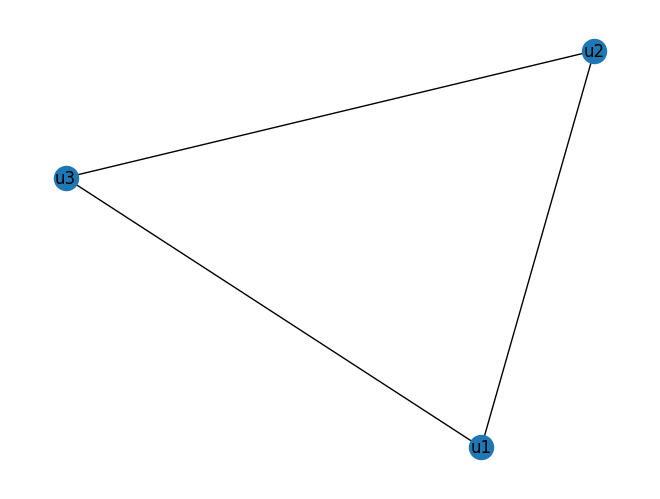

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Конвертация в NetworkX (только для маленьких графов!)
nx_graph = nx.Graph()
for row in edges.collect():
    nx_graph.add_edge(row["src"], row["dst"])

nx.draw(nx_graph, with_labels=True)
plt.show()

#### Основные операции

Найти всех, кого читает пользователь u1  
`followers = graph.edges.filter("src = 'u1' AND relationship = 'follow'")`

Количество исходящих связей для каждой вершины  
`out_degrees = graph.outDegrees`

Топ-3 самых "популярных" пользователей  
`graph.inDegrees.orderBy("inDegree", ascending=False).show(3)`

Найти все пути длиной до 2 шагов от u1
```
paths = graph.bfs(
    fromExpr="id = 'u1'",
    toExpr="id = 'u3'",
    maxPathLength=2
)
```

#### Алгоритмы анализа графов

PageRank — определение важности вершин
```
results = graph.pageRank(resetProbability=0.15, maxIter=10)
results.vertices.orderBy("pagerank", ascending=False).show()
```

Поиск сообществ (LPA)
```
communities = graph.labelPropagation(maxIter=5)
communities.groupBy("label").count().orderBy("count").show()
```

Поиск связных компонентов
```
sc.setCheckpointDir("/tmp")  # Необходимо для больших графов
graph.connectedComponents().show()
```

## 3.5. Интеграция с Python (Pandas, NumPy)

#### Конвертация между PySpark и Pandas DataFrame

Преобразование PySpark → Pandas

```
# Для небольших данных (помещающихся в память)
pandas_df = spark_df.toPandas()

# Для больших данных - партиционированное преобразование
pandas_dfs = []
for partition in spark_df.rdd.mapPartitions(lambda x: [list(x)]).collect():
    pandas_dfs.append(pd.DataFrame(partition))
combined_pandas_df = pd.concat(pandas_dfs)
```

Преобразование Pandas → PySpark
```
from pyspark.sql.types import *

# Автоматическое определение схемы
spark_df = spark.createDataFrame(pandas_df)

# Ручное указание схемы (рекомендуется для сложных структур)
schema = StructType([
    StructField("name", StringType(), True),
    StructField("age", IntegerType(), True)
])
spark_df = spark.createDataFrame(pandas_df, schema=schema)
```

📌 Важно: toPandas() загружает все данные в память драйвера — используйте только для небольших датасетов (<1 ГБ).

#### Использование Pandas UDF (векторизованные функции)

Scalar Pandas UDF
```
from pyspark.sql.functions import pandas_udf
import pandas as pd

@pandas_udf("double")
def squared(s: pd.Series) -> pd.Series:
    return s ** 2

df = df.withColumn("age_squared", squared(df["age"]))
```

Grouped Map Pandas UDF
```
@pandas_udf(df.schema)
def subtract_mean(pdf: pd.DataFrame) -> pd.DataFrame:
    return pdf.assign(age=pdf["age"] - pdf["age"].mean())

df.groupBy("department").applyInPandas(subtract_mean, schema=df.schema)
```

#### Интеграция с NumPy

Конвертация RDD ↔ NumPy
```
# PySpark RDD to NumPy
rdd = spark.sparkContext.parallelize([[1, 2], [3, 4]])
numpy_array = np.array(rdd.collect())

# NumPy to PySpark RDD
numpy_data = np.random.rand(100, 3)
rdd = spark.sparkContext.parallelize(numpy_data.tolist())
```

Оптимизированные операции
```
from pyspark.ml.linalg import Vectors

# Создание распределённой матрицы
matrix_rdd = rdd.map(lambda x: Vectors.dense(x))
```